In [1]:
!pip install catboost

In [2]:
#https://catalog.data.gov/dataset/open-budget-revenue-2010-2021
#https://fred.stlouisfed.org/series/LXXRSA
import pandas as pd
df_budget_revenue = pd.read_csv("https://data.lacity.org/api/views/ih6g-qkwz/rows.csv?accessType=DOWNLOAD")
df_house_prices = pd.read_csv("https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1320&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=LXXRSA&scale=left&cosd=1987-01-01&coed=2024-09-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-11-29&revision_date=2024-11-29&nd=1987-01-01")

In [3]:
df_budget_revenue.columns

Index(['Revenue Source', 'Amount', 'Fund Type', 'Fiscal Year ',
       'Fiscal Year Shorthand'],
      dtype='object')

In [4]:
df_budget_revenue.drop("Fiscal Year ", inplace=True, axis=1)

In [5]:
display(df_budget_revenue)

,Revenue Source,Amount,Fund Type,Fiscal Year Shorthand
0,Business Tax,411960000,General Fund,2011
1,Documentary Transfer Tax,111000000,General Fund,2011
2,Franchise Income,12400000,General Fund,2011
3,Grants Receipts,9200000,General Fund,2011
4,Interest,45541000,General Fund,2011
...,...,...,...,...
1391,Road Maintenance and Rehabilitation Fund,22735918,Available Balances,2025
1392,Measure W Local Return Fund,3755776,Available Balances,2025
1393,Planning Long-Range Planning Fund,2251260,Available Balances,2025
1394,City Planning System Development Fund,4337488,Available Balances,2025


In [6]:
df_house_prices["DATE"] = pd.to_datetime(df_house_prices["DATE"]) #convert column to date
df_house_prices.set_index("DATE", inplace=True) #set index to date
df_house_prices_grp = df_house_prices.groupby((pd.Grouper(freq="YE"))).sum() #groupby year
df_house_prices_grp.reset_index(inplace=True) #reset index
df_house_prices_grp["DATE"] = df_house_prices_grp["DATE"].dt.strftime("%Y") #convert date to year
df_house_prices_grp["DATE"] = pd.to_numeric(df_house_prices_grp["DATE"]) #convert date object to number
df_house_prices_grp.rename(columns={"DATE": "Fiscal Year Shorthand", "LXXRSA": "LA Housing Price"}, inplace=True) #rename columns to match LA Budget dataset
df_house_prices_grp.tail()

,Fiscal Year Shorthand,LA Housing Price
33,2020,3626.456117
34,2021,4230.939993
35,2022,4849.299712
36,2023,4922.338414
37,2024,3923.979662


In [16]:
df_house_prices_grp.index

RangeIndex(start=0, stop=38, step=1)

In [17]:
df = df_budget_revenue.join(df_house_prices_grp.set_index('Fiscal Year Shorthand'), on="Fiscal Year Shorthand", how="left")

In [25]:
df['Fiscal Year Shorthand'] = pd.to_datetime(df['Fiscal Year Shorthand'])

In [38]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

categorical_features_indices = [0, 1]  # 'feature2' is at index 1

X = df[['Revenue Source', 'Fund Type', 'Fiscal Year Shorthand', "LA Housing Price"]]
y = df['Amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features_indices)

model = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.05,
    depth=8,
    verbose=1000,
    early_stopping_rounds=1000,
    has_time=True,
)

model.fit(train_pool, eval_set=test_pool)

y_pred = model.predict(test_pool)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (Test): {rmse:.2f}")

0:	learn: 269106522.8244934	test: 259019417.8196340	best: 259019417.8196340 (0)	total: 3.44ms	remaining: 34.4s
1000:	learn: 15652689.7150851	test: 120684770.8612723	best: 120684770.8612723 (1000)	total: 4.22s	remaining: 38s
2000:	learn: 5483495.4352165	test: 118867801.7966416	best: 118862055.8750206 (1998)	total: 6.61s	remaining: 26.4s
3000:	learn: 2417530.6706912	test: 118306573.4503473	best: 118306279.2308677 (2998)	total: 9.05s	remaining: 21.1s
4000:	learn: 1194398.3489944	test: 118123751.4867501	best: 118122990.5439119 (3984)	total: 11.5s	remaining: 17.2s
5000:	learn: 607693.6874492	test: 118040495.1378889	best: 118040495.1378889 (5000)	total: 15.3s	remaining: 15.3s
6000:	learn: 313325.6192046	test: 118004120.6697557	best: 118003542.1322889 (5990)	total: 18.7s	remaining: 12.4s
7000:	learn: 167004.1952780	test: 117986587.1255442	best: 117986546.5281273 (6998)	total: 21.1s	remaining: 9.03s
8000:	learn: 90600.5371417	test: 117976737.5266194	best: 117976716.5338578 (7996)	total: 23.5s	

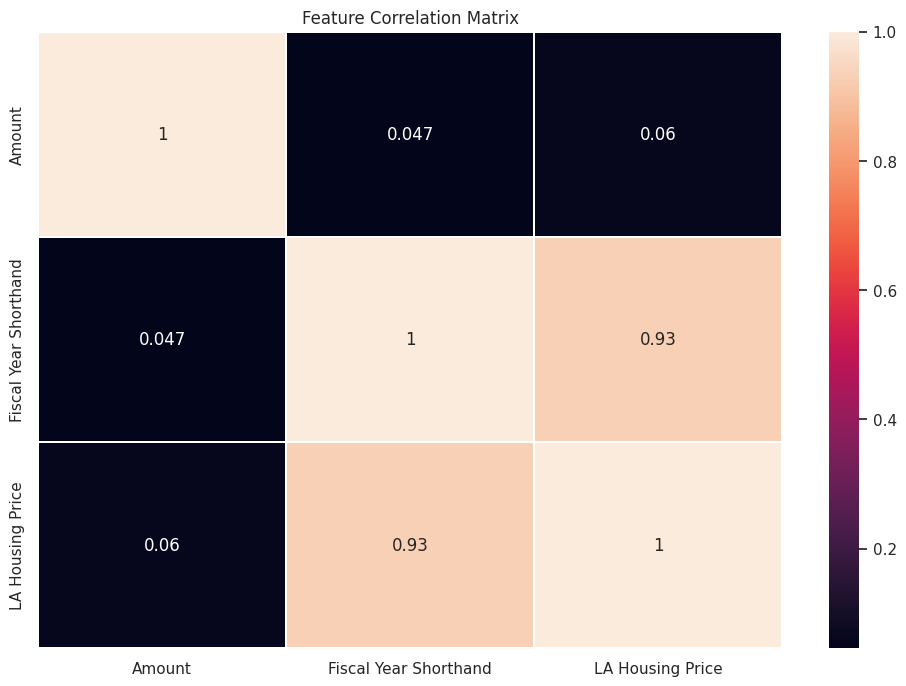

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
correlation_matrix = pd.DataFrame(df.drop(["Revenue Source", "Fund Type"], axis=1)).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, linewidths=0.1)
plt.title("Feature Correlation Matrix")
plt.show()

<ipython-input-45-1656bc5271ed>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='tab10')


<Figure size 1200x800 with 0 Axes>

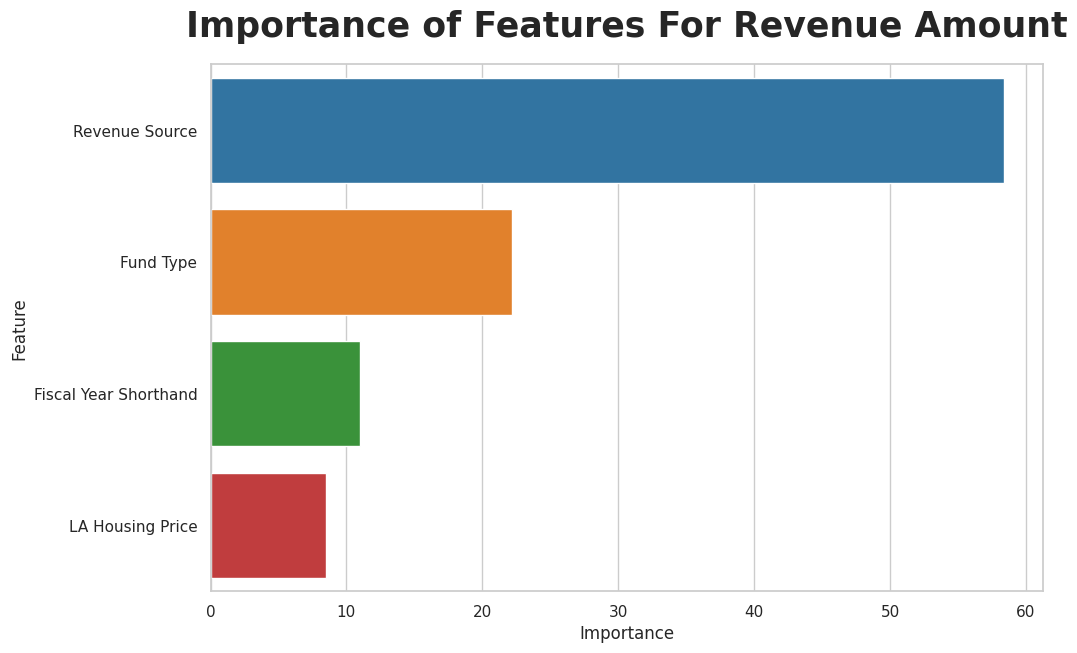

In [45]:
feature_importances = model.get_feature_importance()
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

sns.set_context("talk", font_scale=1.2, rc={'fontweight': 'medium'})
sns.set(font="Liberation Serif")

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='tab10')
plt.title(
    "Importance of Features For Revenue Amount",
    fontdict={'fontsize': 25, 'fontweight': 'bold'},
    pad=20
)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout(pad=5.0)
plt.show()